## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from sklearn import set_config
from sklearn.preprocessing import MaxAbsScaler
from tqdm.notebook import tqdm

set_config(transform_output="pandas")


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Read Data

In [2]:
data_df = pd.read_csv(
    "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/mmm_roas_data.csv",
    parse_dates=["date"],
)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  131 non-null    datetime64[ns]
 1   dayofyear             131 non-null    int64         
 2   quarter               131 non-null    object        
 3   trend                 131 non-null    float64       
 4   cs                    131 non-null    float64       
 5   cc                    131 non-null    float64       
 6   seasonality           131 non-null    float64       
 7   z                     131 non-null    float64       
 8   x1                    131 non-null    float64       
 9   x2                    131 non-null    float64       
 10  epsilon               131 non-null    float64       
 11  x1_adstock            131 non-null    float64       
 12  x2_adstock            131 non-null    float64       
 13  x1_adstock_saturated

Text(0.5, 0.98, 'Data Generating Process')

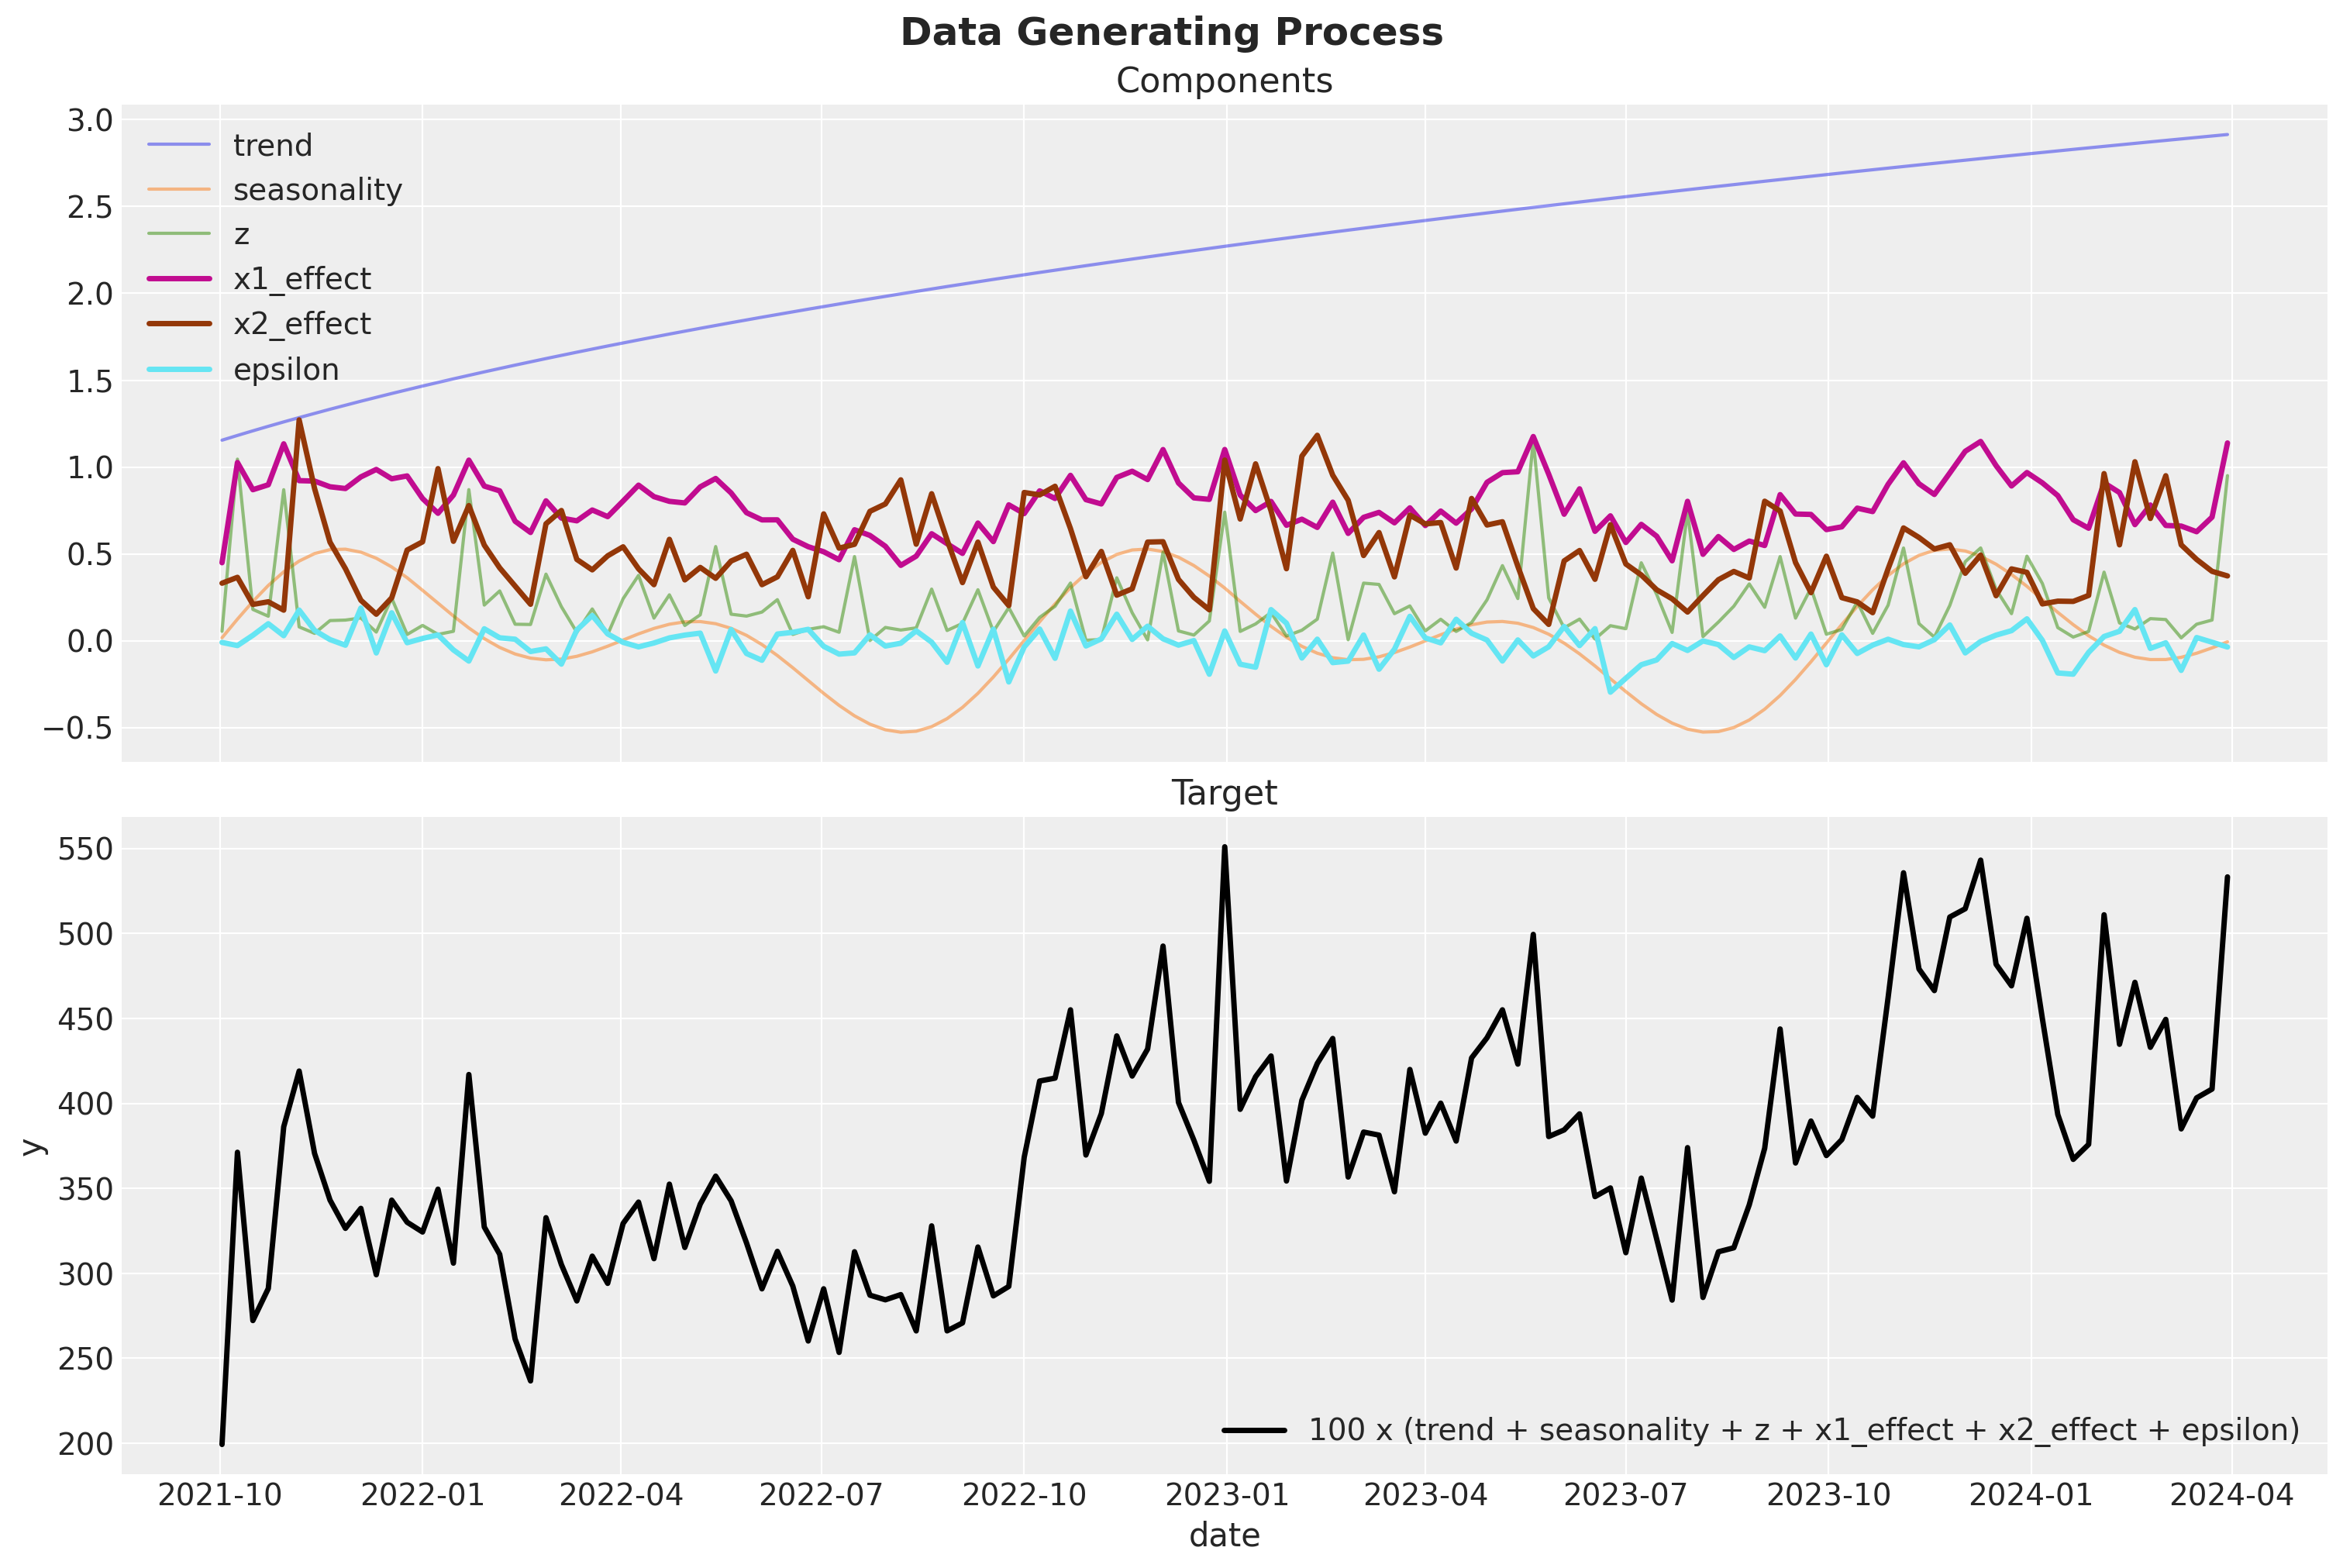

In [3]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date", y="z", color="C2", alpha=0.5, label="z", ax=ax[0])
sns.lineplot(
    data=data_df,
    x="date",
    y="x1_effect",
    color="C3",
    linewidth=2.5,
    label="x1_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="x2_effect",
    color="C4",
    linewidth=2.5,
    label="x2_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(title="Components", xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    linewidth=2.5,
    label="100 x (trend + seasonality + z + x1_effect + x2_effect + epsilon)",
    ax=ax[1],
)
ax[1].legend(loc="lower right")
ax[1].set(title="Target")

fig.suptitle(t="Data Generating Process", fontsize=18, fontweight="bold")

Text(0.5, 0.98, 'Channel Contributions - Original')

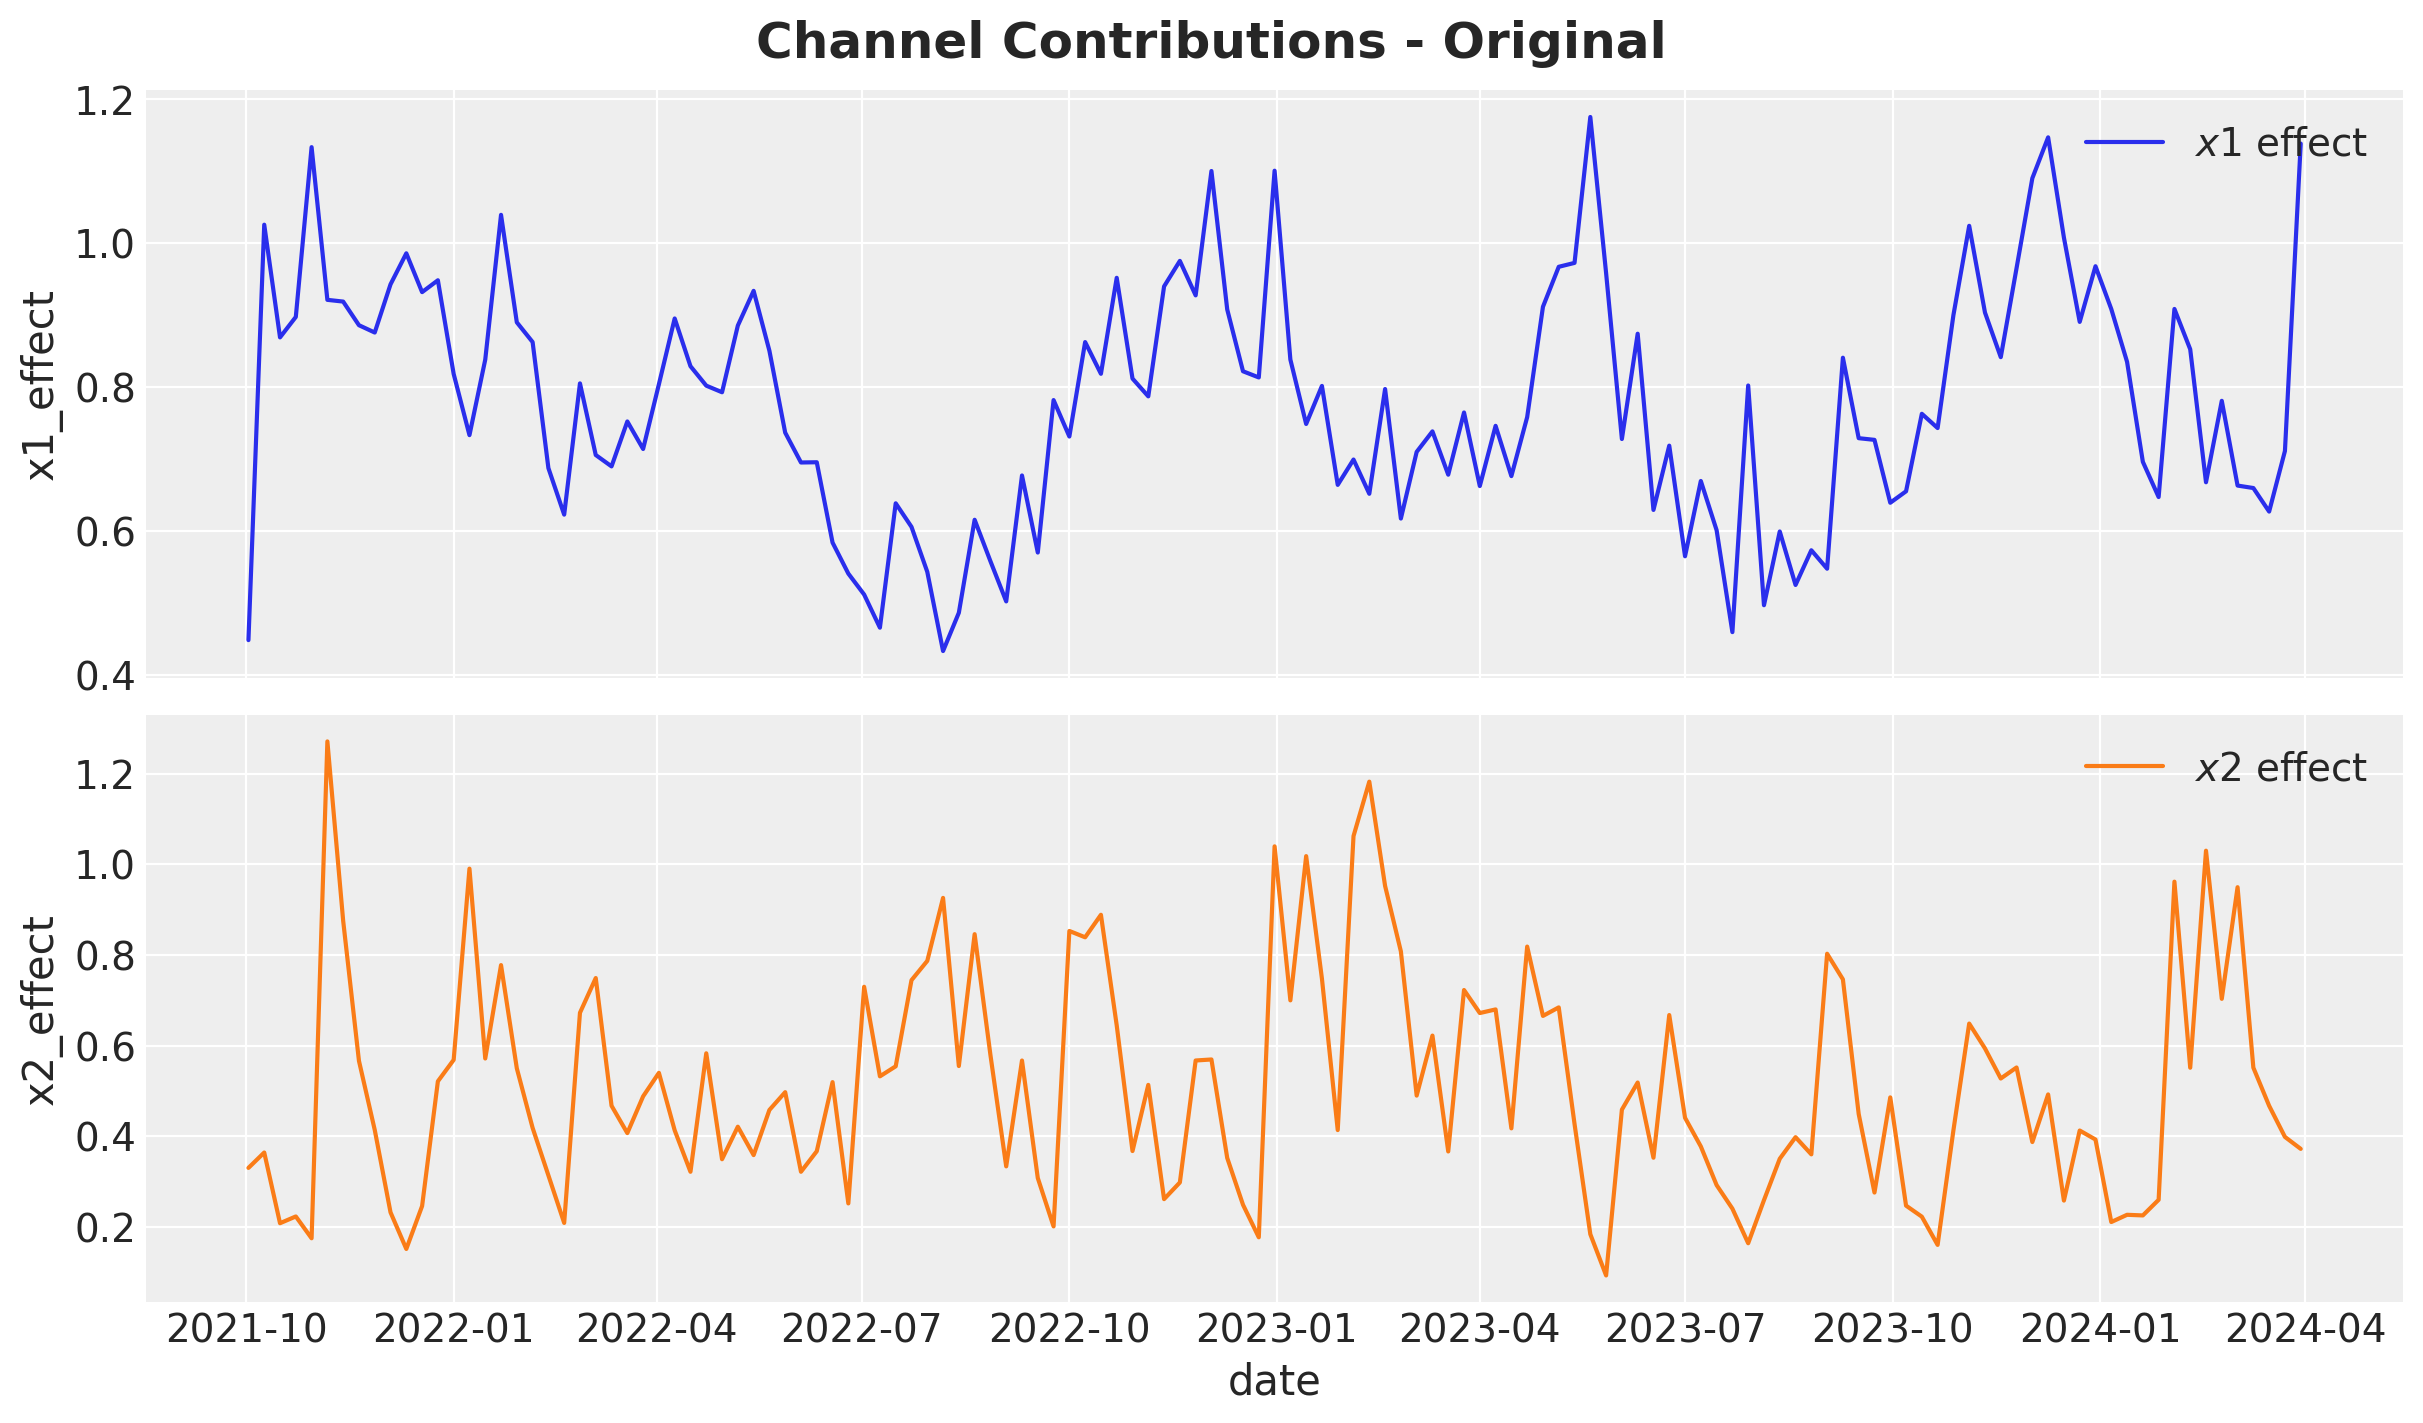

In [4]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(
    x="date",
    y="x1_effect",
    data=data_df,
    color="C0",
    label=r"$x1$ effect",
    ax=ax[0],
)

ax[0].legend(loc="upper right")

sns.lineplot(
    x="date",
    y="x2_effect",
    data=data_df,
    color="C1",
    label=r"$x2$ effect",
    ax=ax[1],
)
ax[1].legend(loc="upper right")

fig.suptitle("Channel Contributions - Original", fontsize=18, fontweight="bold")

## Time Varying Media Coefficients

In [5]:
data_df = data_df.eval(
    """
    r = index / index.max()
    g1 = exp(-r / 3)
    g2 = log(r + 2)
    x1_effect_tv = g1 * x1_effect
    x2_effect_tv = g2 * x2_effect
    """
)

Text(0.5, 0.98, 'Channel Contributions - Original')

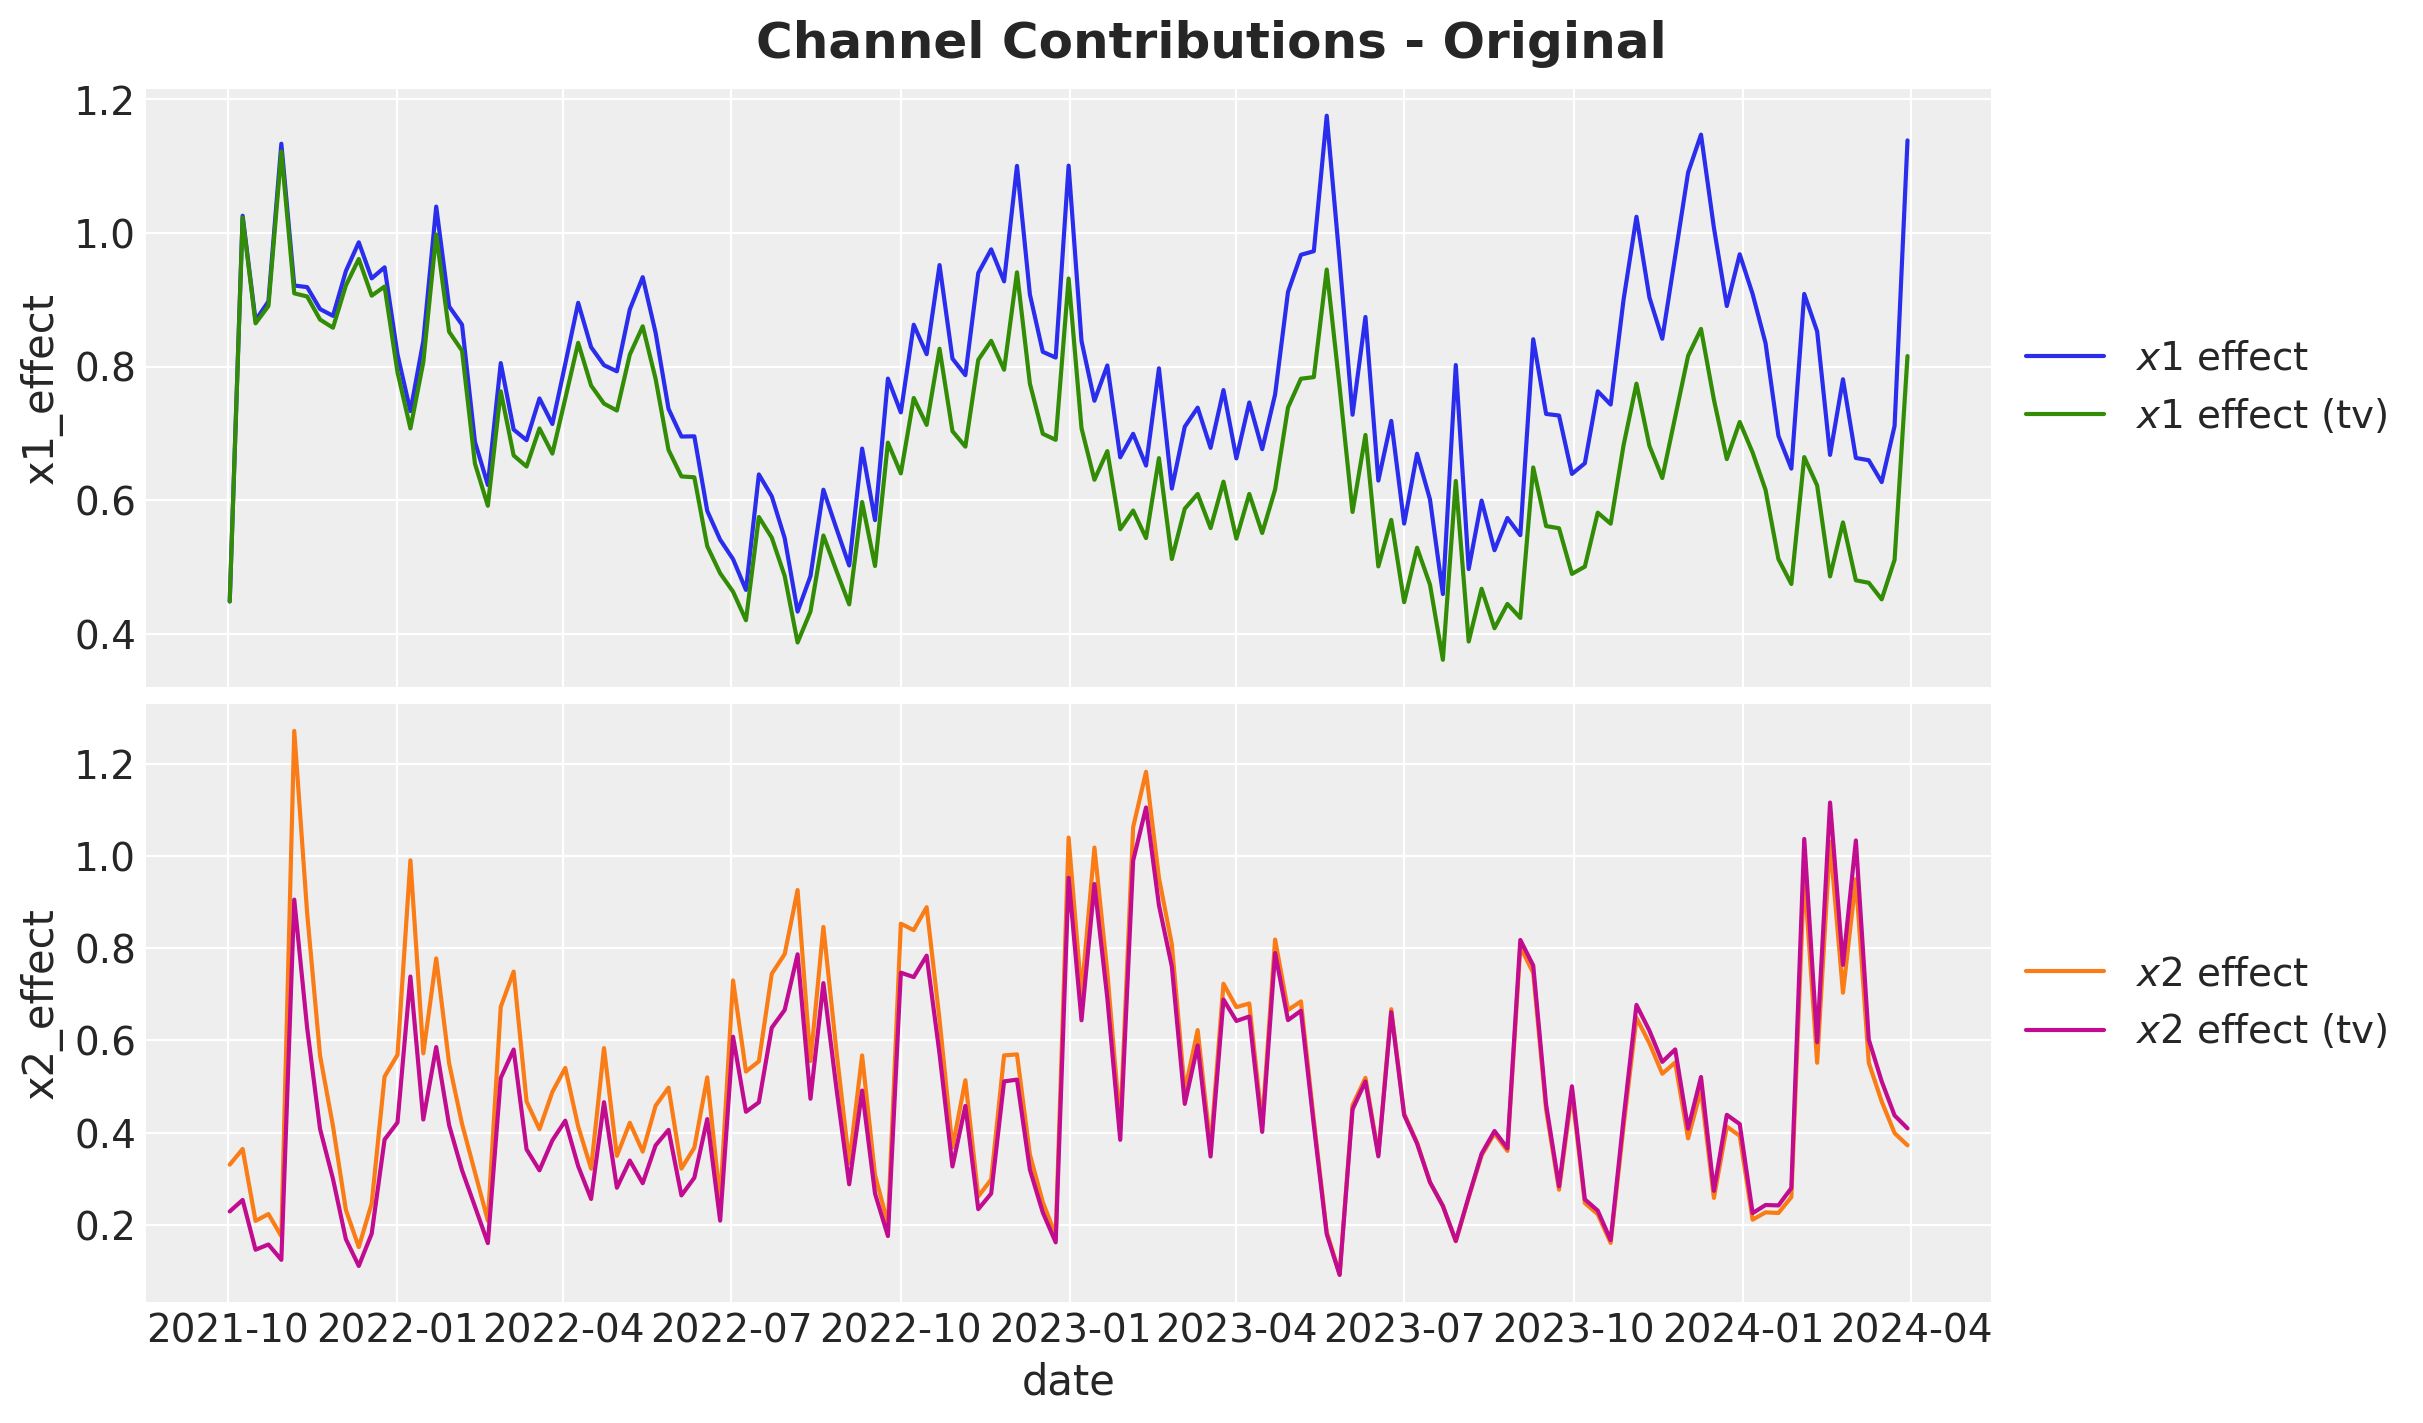

In [6]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(
    x="date",
    y="x1_effect",
    data=data_df,
    color="C0",
    label=r"$x1$ effect",
    ax=ax[0],
)
sns.lineplot(
    x="date",
    y="x1_effect_tv",
    data=data_df,
    color="C2",
    label=r"$x1$ effect (tv)",
    ax=ax[0],
)

ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.lineplot(
    x="date",
    y="x2_effect",
    data=data_df,
    color="C1",
    label=r"$x2$ effect",
    ax=ax[1],
)
sns.lineplot(
    x="date",
    y="x2_effect_tv",
    data=data_df,
    color="C3",
    label=r"$x2$ effect (tv)",
    ax=ax[1],
)
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.suptitle("Channel Contributions - Original", fontsize=18, fontweight="bold")

In [7]:
beta1 = 2.0
beta2 = 1.5
amplitude = 100

data_df = data_df.eval(
    f"""
    base = trend + seasonality + z
    y_tv = {amplitude} * (base + x1_effect_tv + x2_effect_tv + epsilon)
    y01_tv = {amplitude} * (base + x2_effect_tv + epsilon)
    y02_tv = {amplitude} * (base + x1_effect_tv + epsilon)
    """
)

[Text(0.5, 1.0, 'Target Comparison'), Text(0.5, 0, 'date'), Text(0, 0.5, '')]

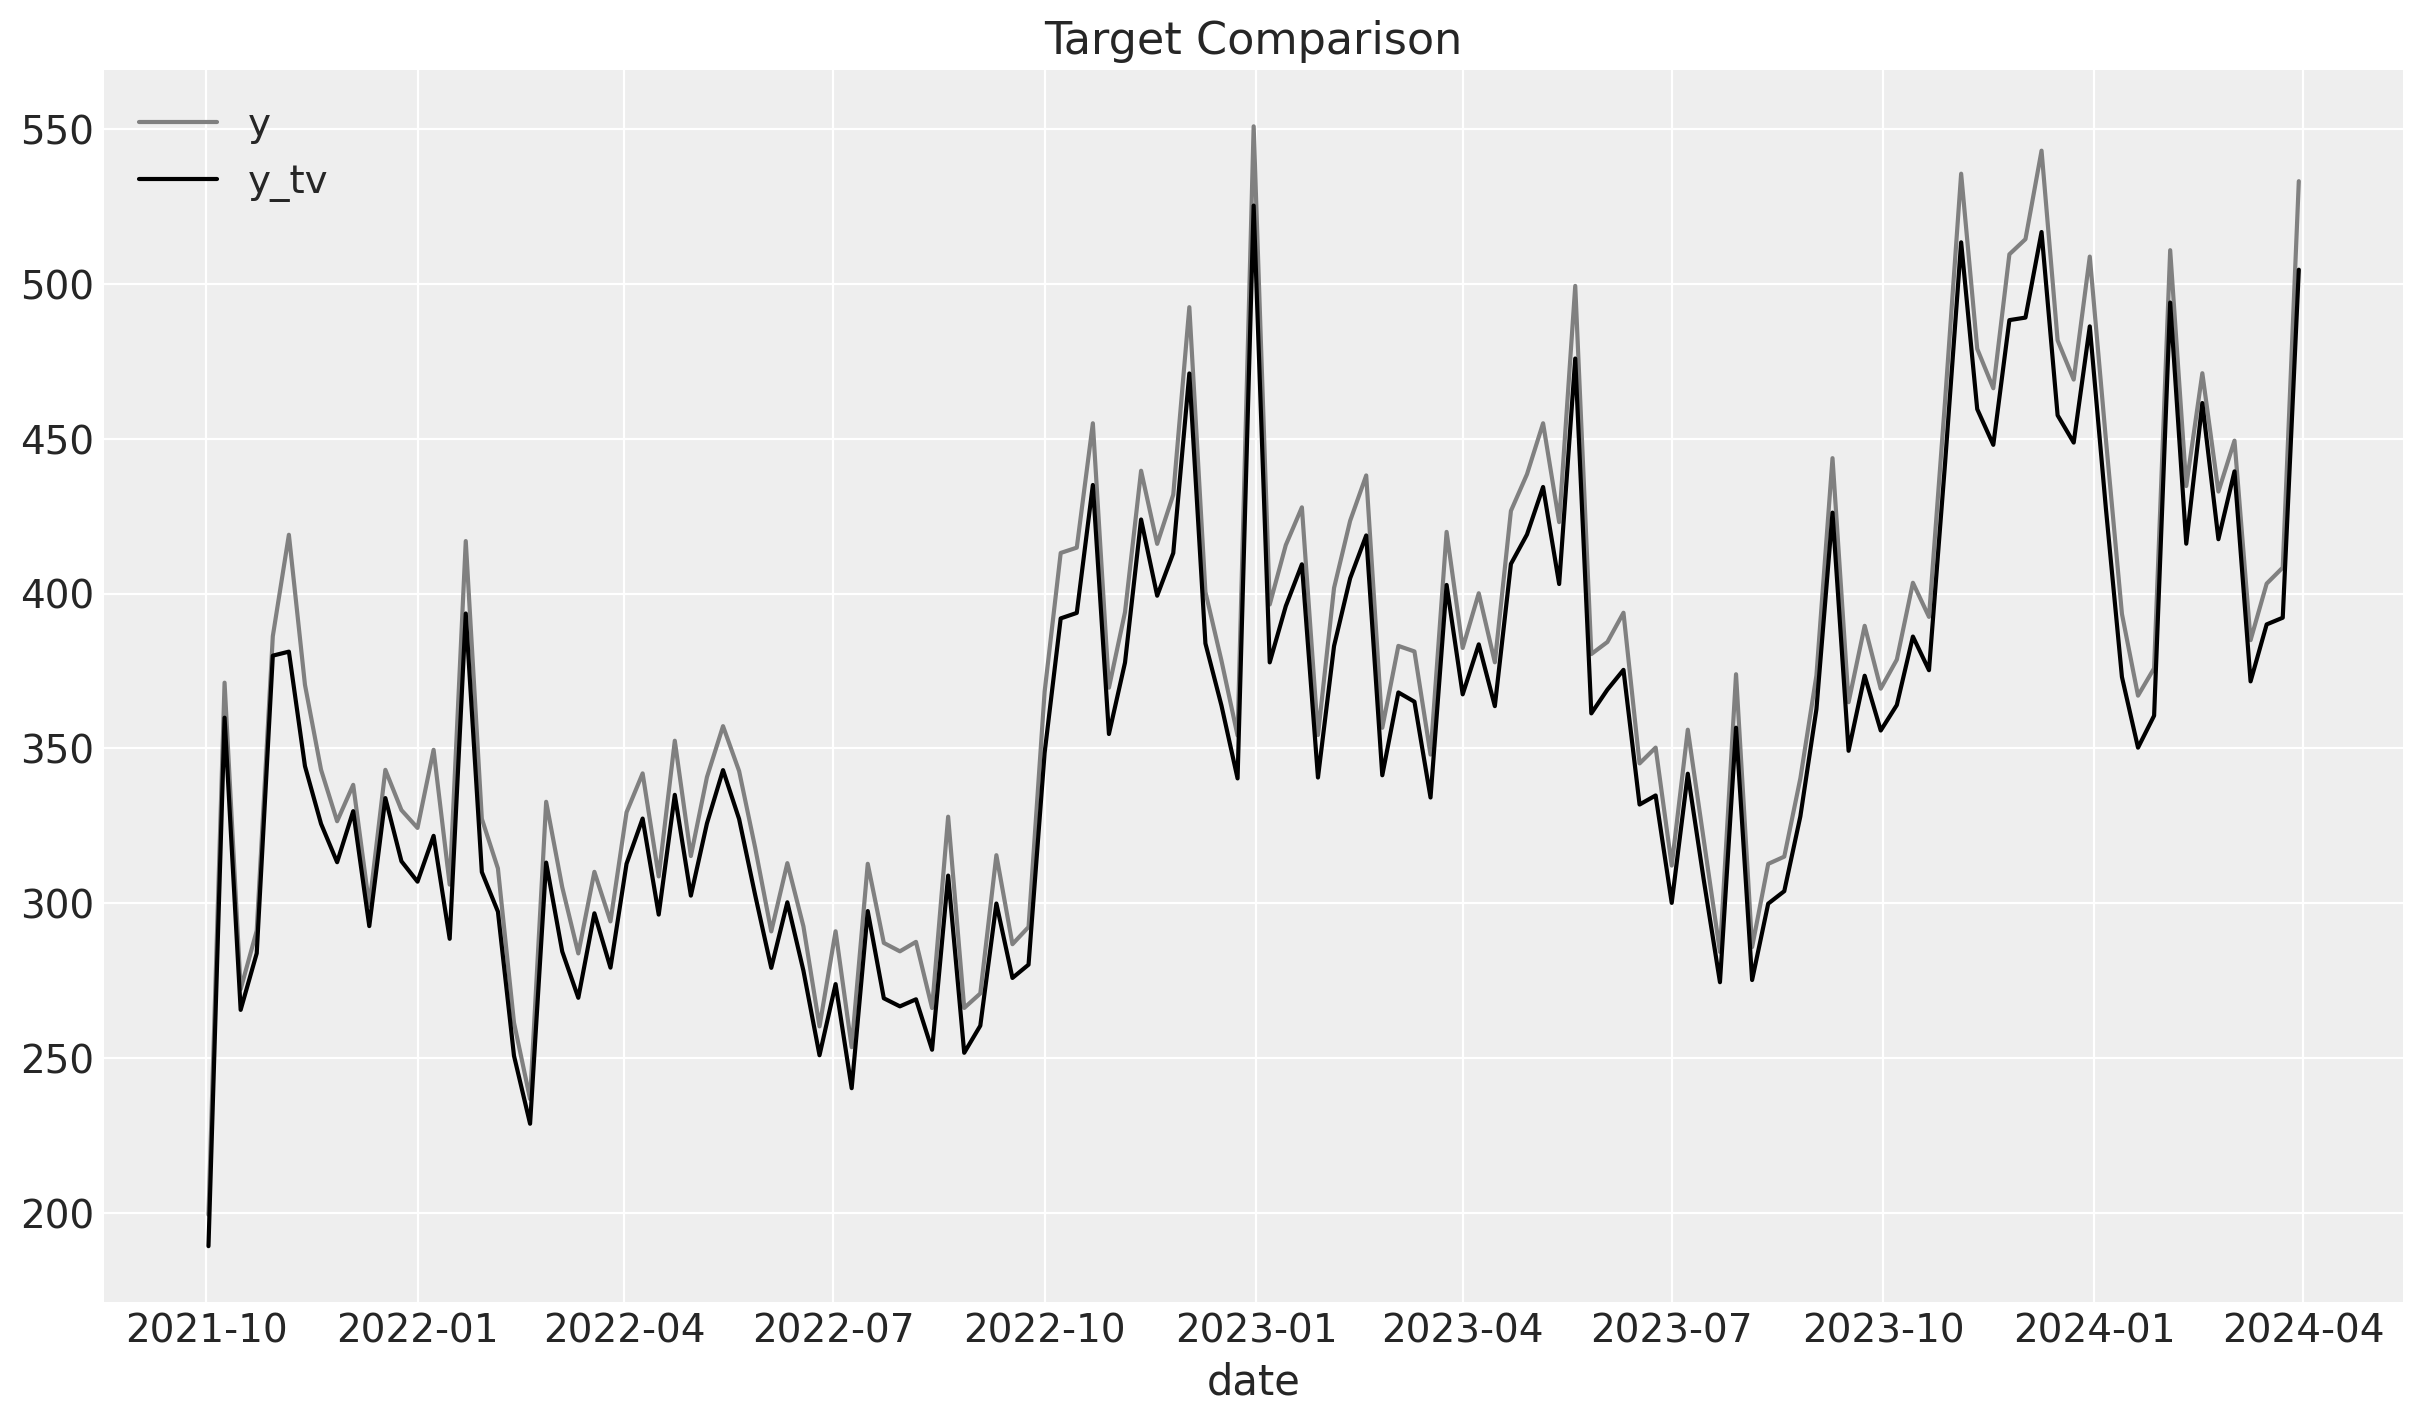

In [8]:
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="y",
    data=data_df,
    color="gray",
    label="y",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="y_tv",
    data=data_df,
    color="black",
    label="y_tv",
    ax=ax,
)
ax.set(title="Target Comparison", xlabel="date", ylabel=None)

## ROAS

In [9]:
def geometric_adstock(x, alpha, l_max, normalize):
    """Vectorized geometric adstock transformation."""
    cycles = [
        pt.concatenate(tensor_list=[pt.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    x_cycle = pt.transpose(x=x_cycle, axes=[1, 2, 0])
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    w = pt.transpose(w)[None, ...]
    w = w / pt.sum(w, axis=2, keepdims=True) if normalize else w
    return pt.sum(pt.mul(x_cycle, w), axis=2)


def logistic_saturation(x, lam):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

In [10]:
def generate_potential_y(
    dataset, alpha, l_max, lambda_, beta1, beta2, amplitude, channel, t0, t1
):
    dataset = dataset.copy()
    dataset["mask"] = ~dataset["date"].between(left=t0, right=t1, inclusive="both")
    dataset[channel] = dataset[channel].where(cond=dataset["mask"], other=0)
    dataset[["x1_adstock", "x2_adstock"]] = geometric_adstock(
        x=dataset[["x1", "x2"]], alpha=alpha, l_max=l_max, normalize=True
    ).eval()
    dataset[["x1_adstock_saturated", "x2_adstock_saturated"]] = logistic_saturation(
        x=dataset[["x1_adstock", "x2_adstock"]], lam=lambda_
    ).eval()
    return dataset.eval(
        f"""
        x1_effect = {beta1} * x1_adstock_saturated
        x2_effect = {beta2} * x2_adstock_saturated
        r = index / index.max()
        g1 = exp(-r / 3)
        g2 = log(r + 2)
        x1_effect_tv = g1 * x1_effect
        x2_effect_tv = g2 * x2_effect
        base = trend + seasonality + z
        y_tv = {amplitude} * (base + x1_effect_tv + x2_effect_tv + epsilon)
        """
    )

In [11]:
quarter_ranges = data_df.groupby("quarter", as_index=False).agg(
    {"date": ["min", "max"]}
)

quarter_ranges.head()

quarter       date           
                 min        max
0  2021Q4 2021-10-02 2021-12-25
1  2022Q1 2022-01-01 2022-03-26
2  2022Q2 2022-04-02 2022-06-25
3  2022Q3 2022-07-02 2022-09-24
4  2022Q4 2022-10-01 2022-12-31

In [12]:
l_max = 4

alpha1 = 0.3
alpha2 = 0.5
alpha = np.array([alpha1, alpha2])

lam1 = 1.0
lam2 = 2.5

lam = np.array([lam1, lam2])

beta1 = 2.0
beta2 = 1.5
amplitude = 100

roas_data = {
    channel: {
        row["quarter"].item(): generate_potential_y(
            dataset=data_df,
            alpha=alpha,
            l_max=l_max,
            lambda_=lam,
            beta1=beta1,
            beta2=beta2,
            amplitude=amplitude,
            channel=channel,
            t0=row["date"]["min"],
            t1=row["date"]["max"],
        )
        for _, row in tqdm(quarter_ranges.iterrows())
    }
    for channel in ["x1", "x2"]
}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
roas_x1 = pd.DataFrame.from_dict(
    data={
        q: (
            (data_df["y_tv"].sum() - q_df["y_tv"].sum())
            / data_df.query("quarter == @q")["x1"].sum()
        )
        for q, q_df in roas_data["x1"].items()
    },
    orient="index",
    columns=["roas"],
).assign(channel="x1")


roas_x2 = pd.DataFrame.from_dict(
    data={
        q: (
            (data_df["y_tv"].sum() - q_df["y_tv"].sum())
            / data_df.query("quarter == @q")["x2"].sum()
        )
        for q, q_df in roas_data["x2"].items()
    },
    orient="index",
    columns=["roas"],
).assign(channel="x2")

In [14]:
roas_all_1 = (data_df["y_tv"] - data_df["y01_tv"]).sum() / data_df["x1"].sum()

roas_all_2 = (data_df["y_tv"] - data_df["y02_tv"]).sum() / data_df["x2"].sum()

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.03, 'True ROAS')

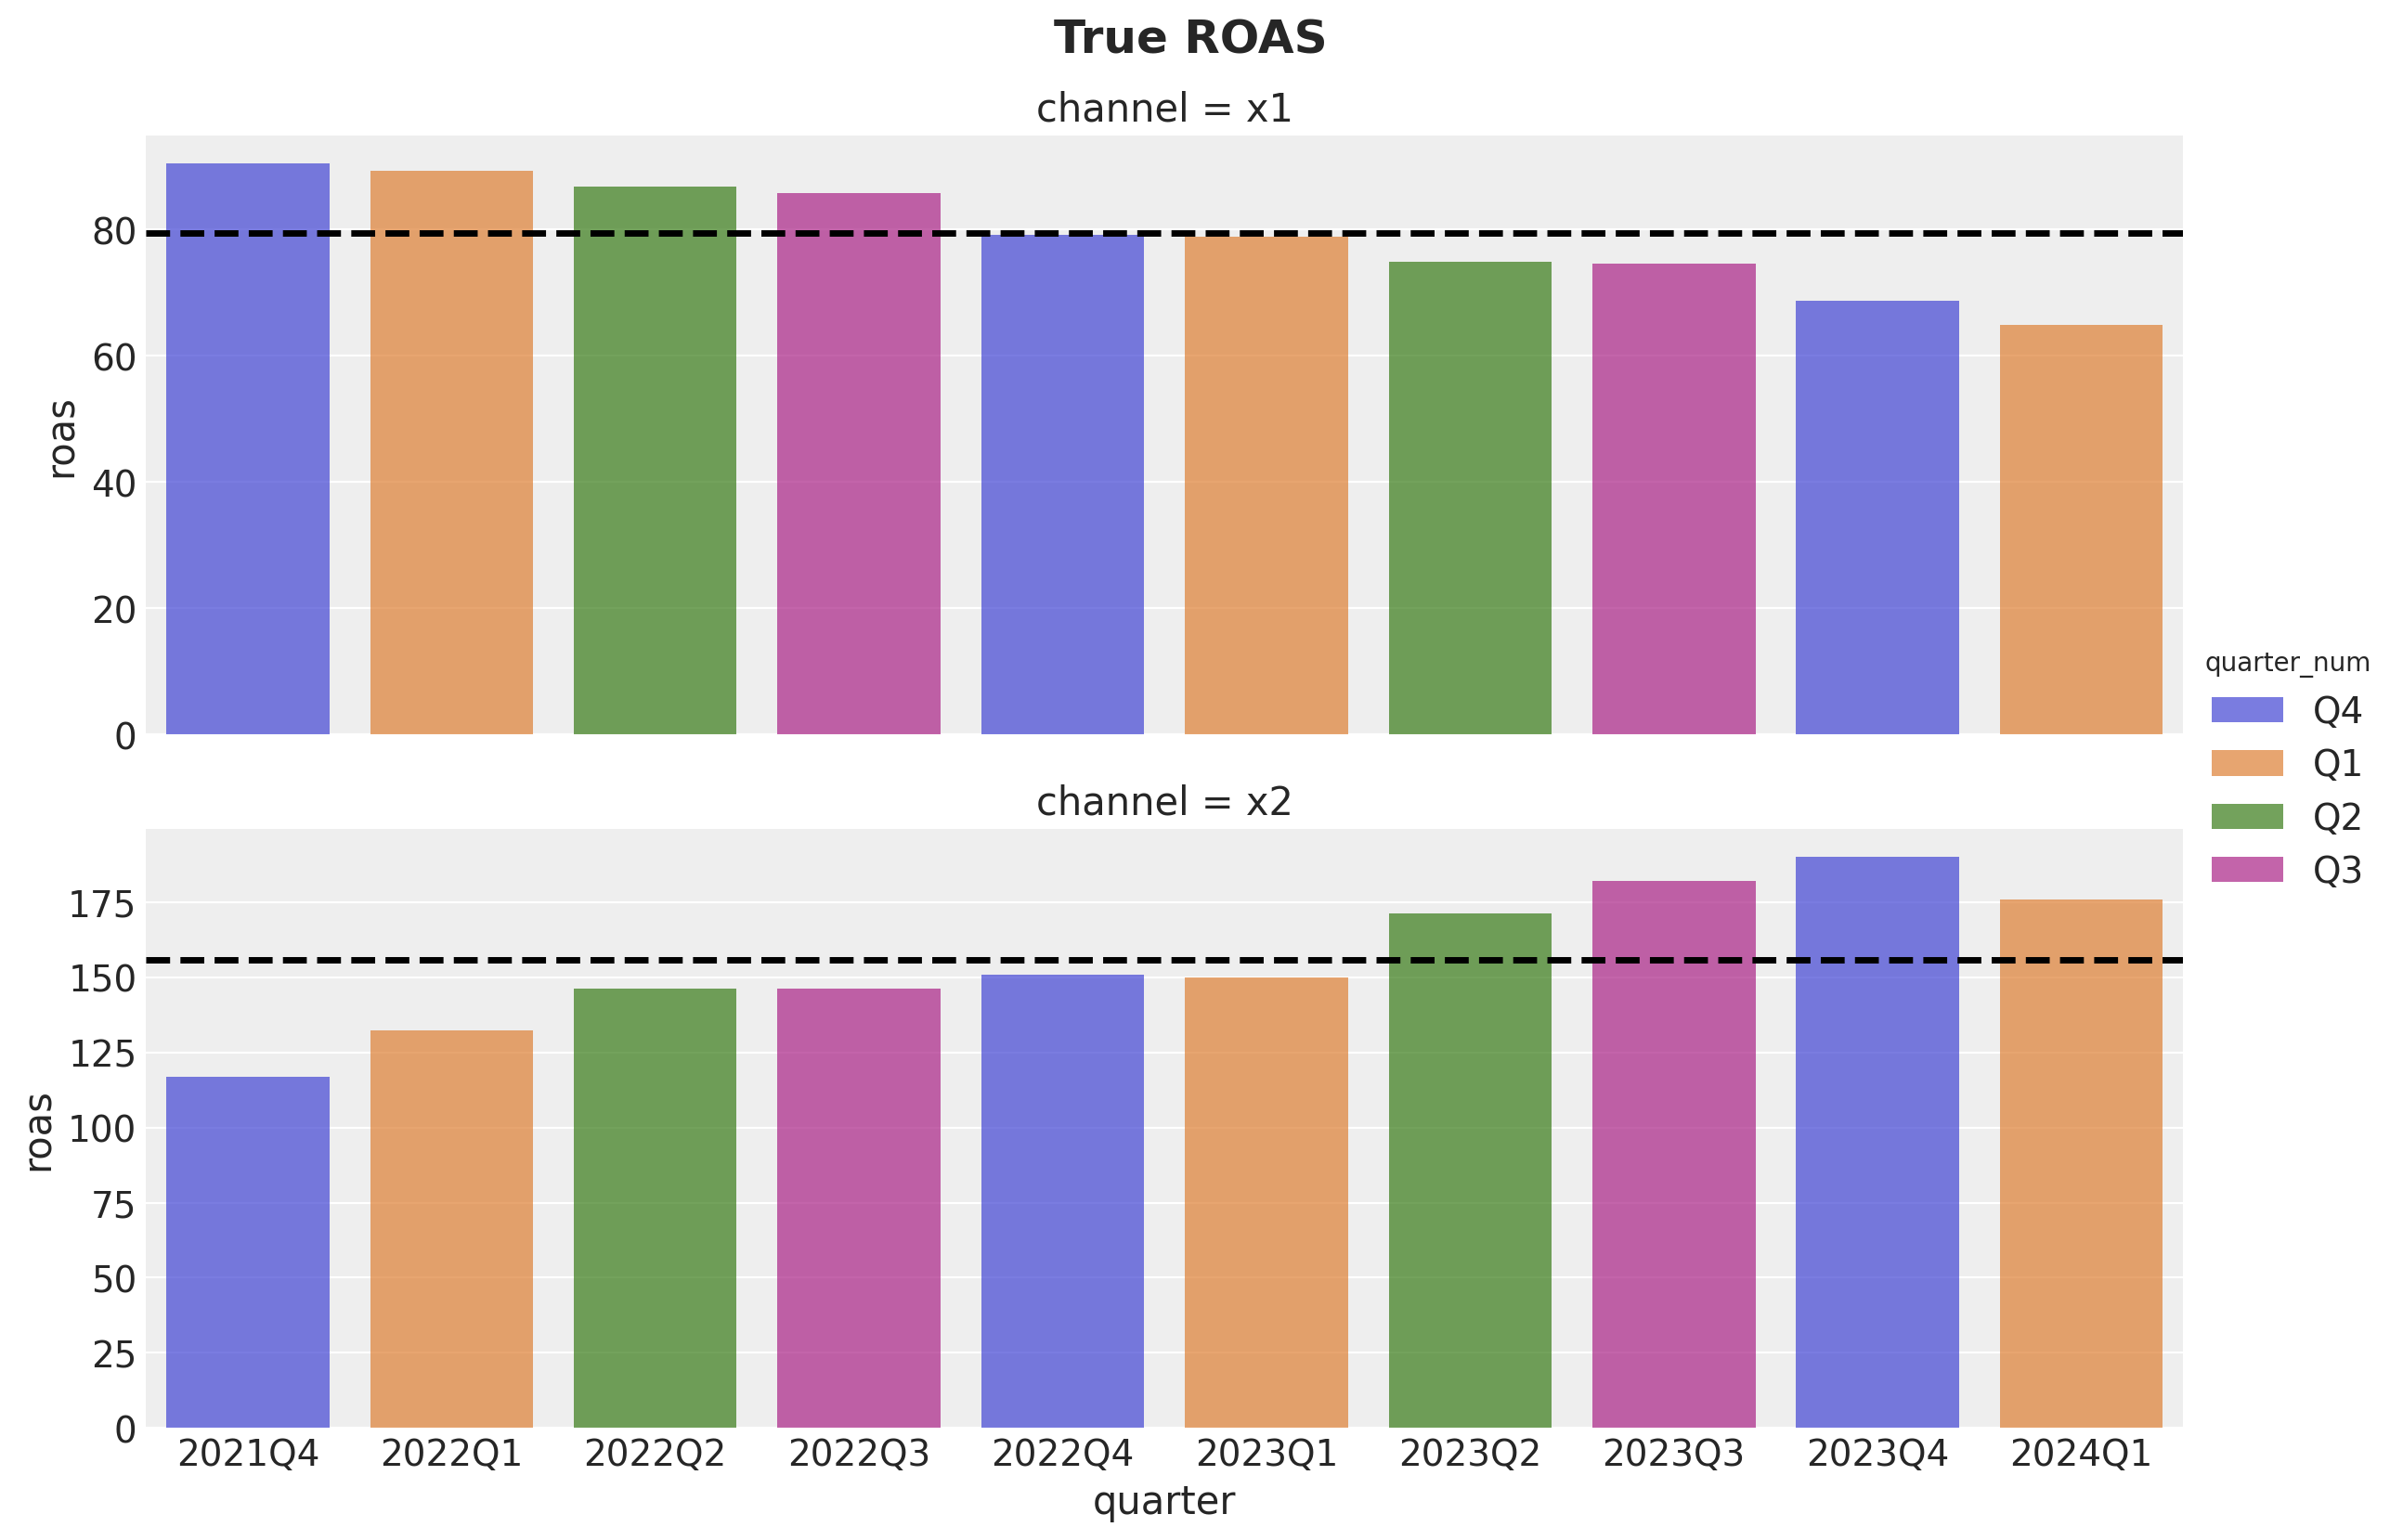

In [15]:
roas = (
    pd.concat(objs=[roas_x1, roas_x2], axis=0)
    .reset_index(drop=False)
    .rename(columns={"index": "quarter"})
)

g = sns.catplot(
    data=roas.assign(quarter_num=lambda df: df.quarter.str[4:]),
    x="quarter",
    y="roas",
    row="channel",
    hue="quarter_num",
    kind="bar",
    height=4,
    aspect=3,
    alpha=0.7,
    sharey=False,
)

ax = g.axes.flatten()
ax[0].axhline(
    y=roas_all_1, color="black", linestyle="--", linewidth=2.5, label="roas (all)"
)
ax[1].axhline(
    y=roas_all_2, color="black", linestyle="--", linewidth=2.5, label="roas (all)"
)

g.fig.suptitle(t="True ROAS", fontsize=18, fontweight="bold", y=1.03)

## Data Preparation

In [16]:
columns_to_keep = [
    "date",
    "dayofyear",
    "z",
    "x1",
    "x2",
    "y_tv",
]

model_df = data_df[columns_to_keep]

model_df.head()

,date,dayofyear,z,x1,x2,y_tv
0,2021-10-02,275,0.053693,0.646554,0.336188,189.182956
1,2021-10-09,282,1.045243,1.411917,0.203931,359.927071
2,2021-10-16,289,0.179703,0.837610,0.024026,265.527946
3,2021-10-23,296,0.140496,0.973612,0.120257,283.811560
4,2021-10-30,303,0.869155,1.415985,0.084630,379.970475


In [17]:
date = model_df["date"]

index_scaler = MaxAbsScaler()
index_scaled = index_scaler.fit_transform(model_df.reset_index(drop=False)[["index"]])

target = "y_tv"
target_scaler = MaxAbsScaler()
target_scaled = target_scaler.fit_transform(model_df[[target]])

channels = ["x1", "x2"]
channels_scaler = MaxAbsScaler()
channels_scaled = channels_scaler.fit_transform(model_df[channels])

controls = ["z"]
controls_scaler = MaxAbsScaler()
controls_scaled = controls_scaler.fit_transform(model_df[controls])

In [18]:
n_order = 3
periods = model_df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

Text(0.5, 1.0, 'Prior Distribution ROAS')

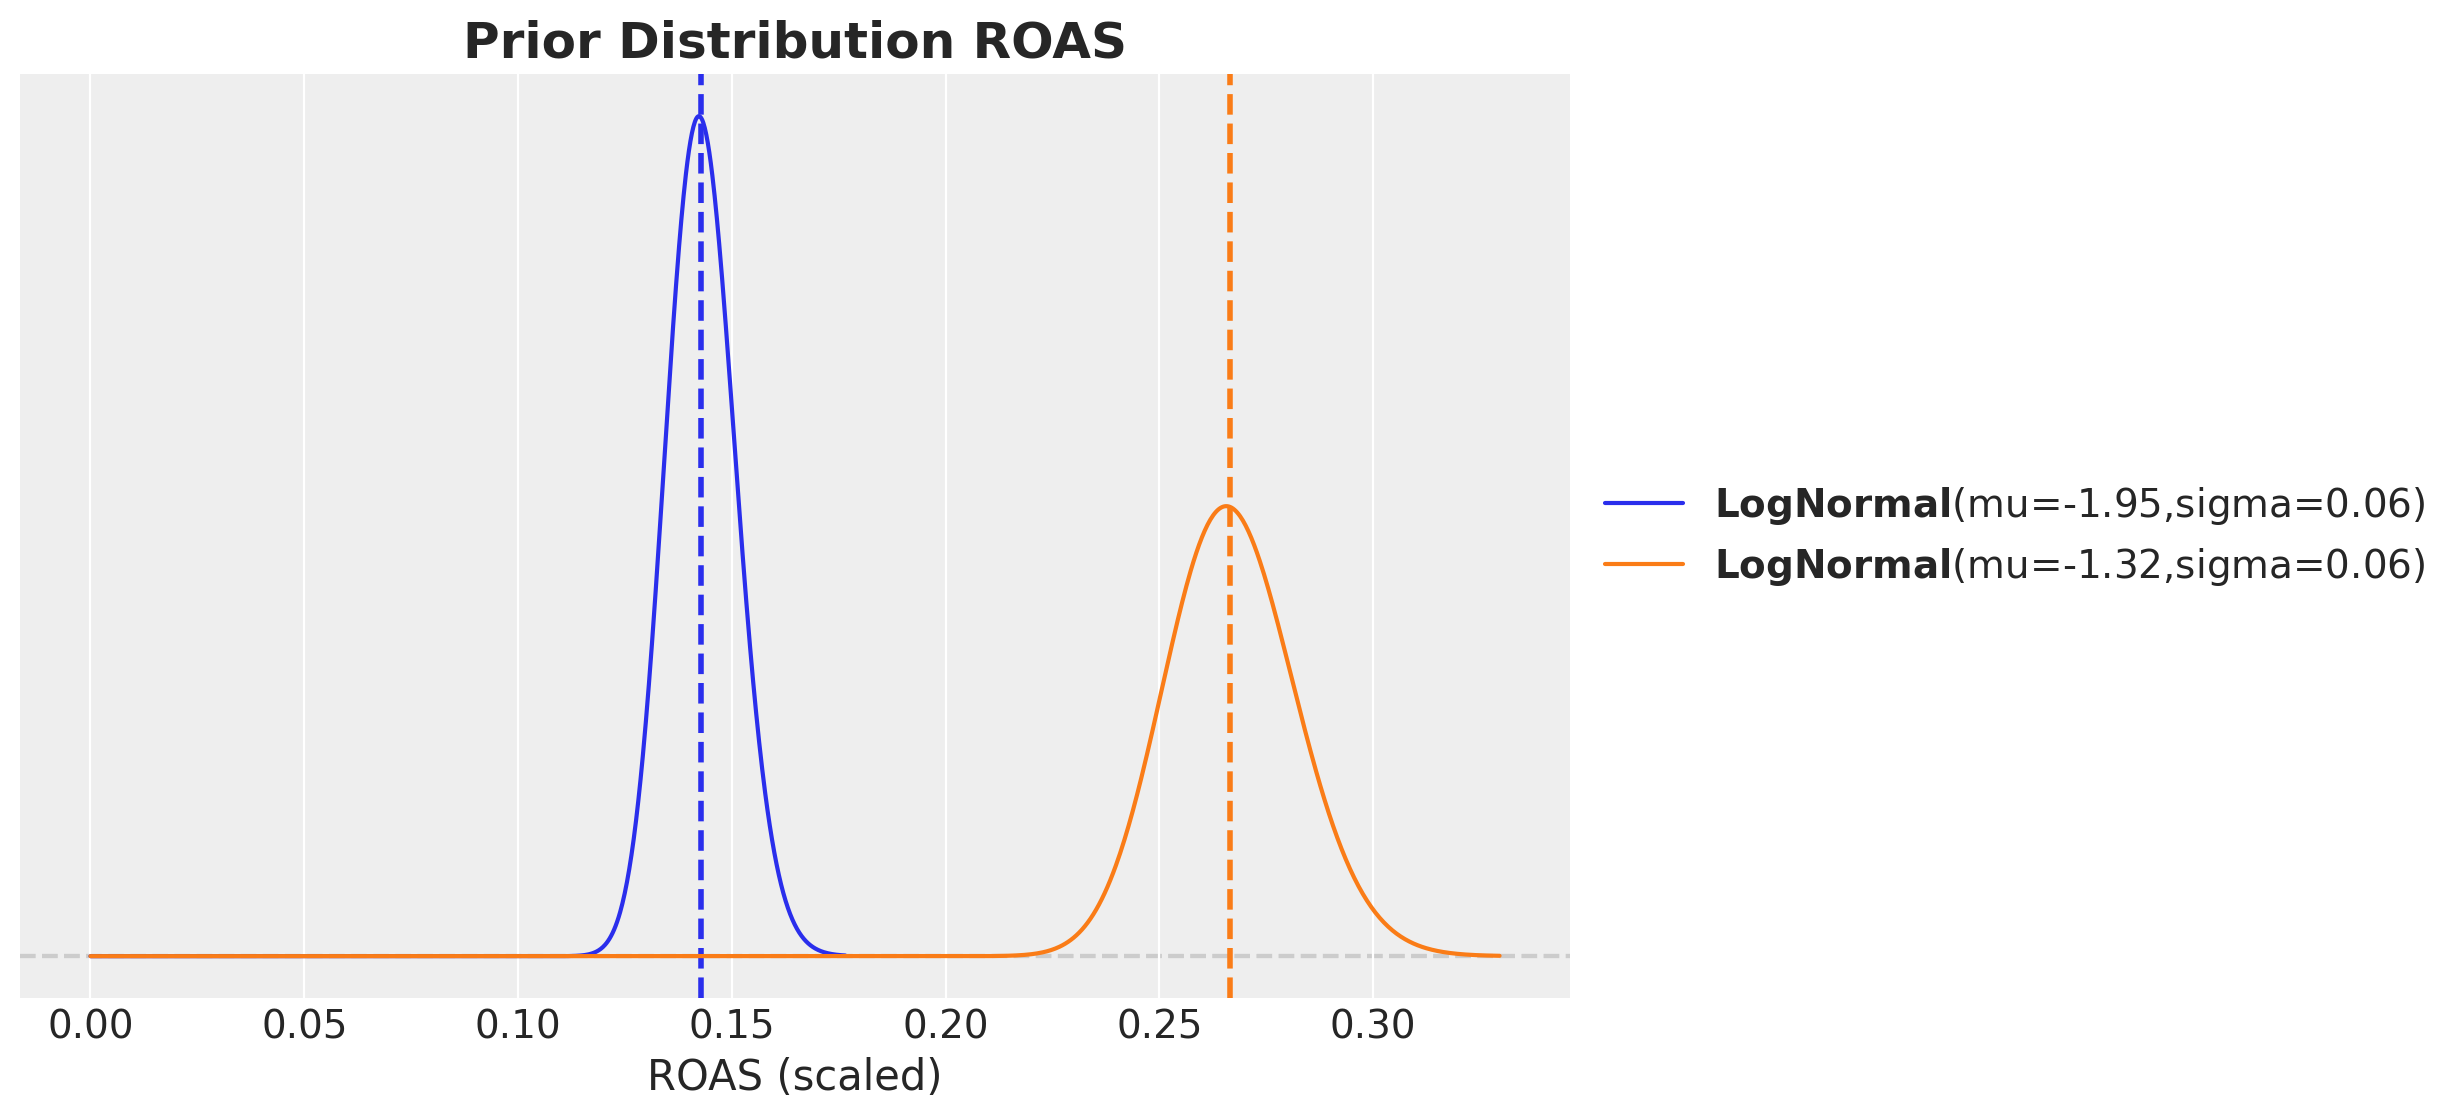

In [19]:
roas_x1_bar = 75
roas_x2_bar = 140

roas_x1_bar_scaled = roas_x1_bar / target_scaler.scale_.item()
roas_x2_bar_scaled = roas_x2_bar / target_scaler.scale_.item()

roas_bar_scaled = np.array([roas_x1_bar_scaled, roas_x2_bar_scaled])

error = 30
error_scaled = error / target_scaler.scale_.item()


fig, ax = plt.subplots(figsize=(10, 6))
pz.LogNormal(mu=np.log(roas_x1_bar_scaled), sigma=error_scaled).plot_pdf(
    color="C0", ax=ax
)
ax.axvline(x=roas_x1_bar_scaled, color="C0", linestyle="--", linewidth=2)
pz.LogNormal(mu=np.log(roas_x2_bar_scaled), sigma=error_scaled).plot_pdf(
    color="C1", ax=ax
)
ax.axvline(x=roas_x2_bar_scaled, color="C1", linestyle="--", linewidth=2)
ax.set(xlabel="ROAS (scaled)")
ax.set_title(label=r"Prior Distribution ROAS", fontsize=18, fontweight="bold")

In [20]:
coords = {"date": date, "channel": channels, "fourier_mode": np.arange(2 * n_order)}

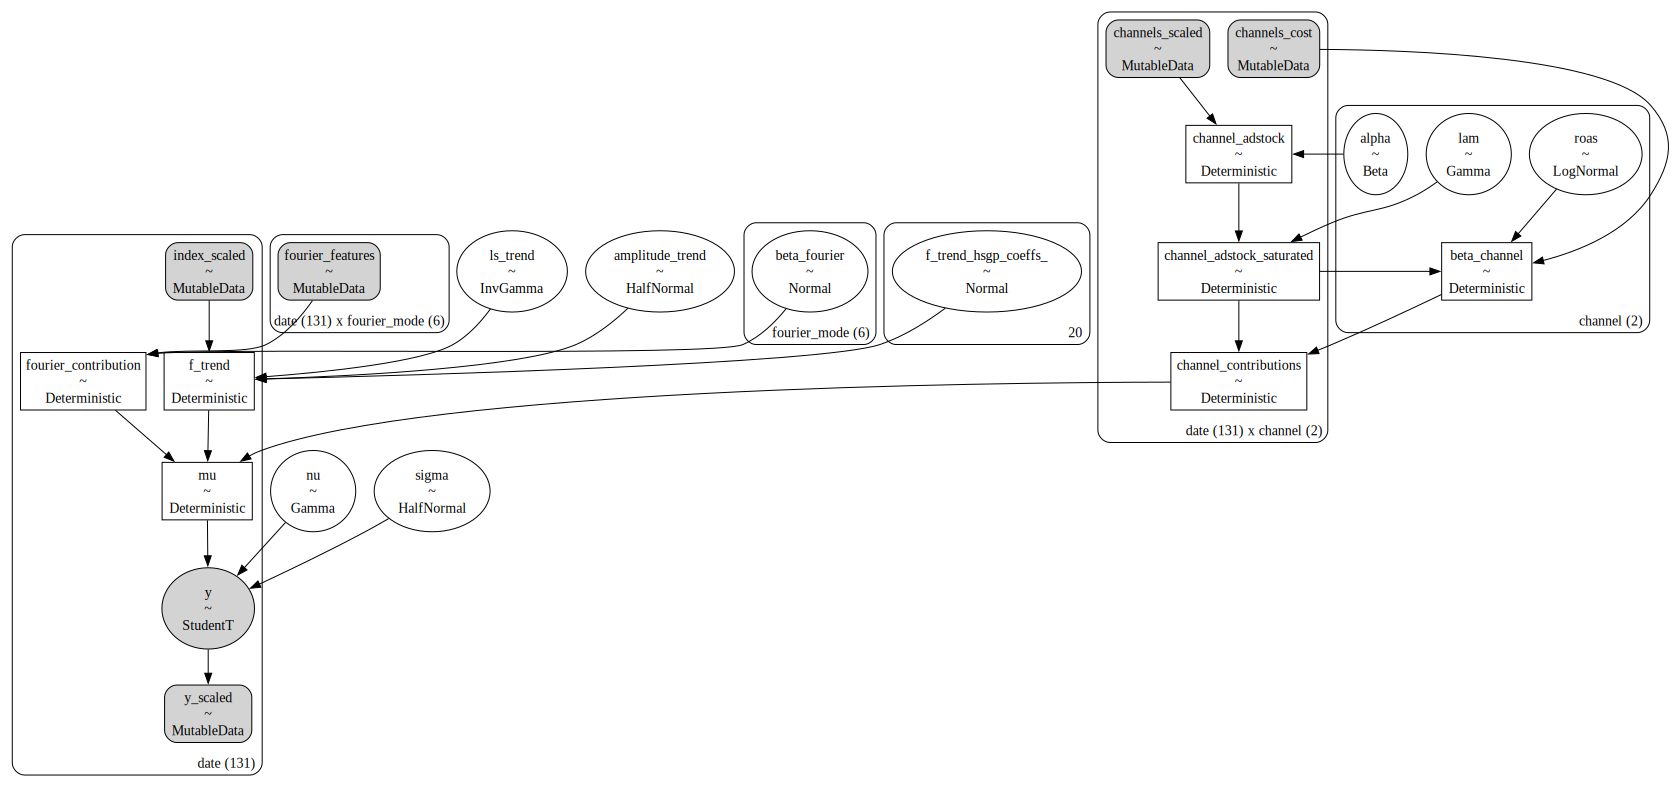

In [21]:
eps = np.finfo(float).eps


with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    index_scaled_data = pm.Data(
        name="index_scaled",
        value=index_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    channels_scaled_data = pm.Data(
        name="channels_scaled",
        value=channels_scaled,
        mutable=True,
        dims=("date", "channel"),
    )

    channels_cost_data = pm.Data(
        name="channels_cost",
        value=data_df[channels].to_numpy(),
        mutable=True,
        dims=("date", "channel"),
    )

    fourier_features_data = pm.Data(
        name="fourier_features",
        value=fourier_features,
        mutable=True,
        dims=("date", "fourier_mode"),
    )

    y_scaled_data = pm.Data(
        name="y_scaled",
        value=target_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    # --- Priors ---

    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1)
    ls_trend_params = pm.find_constrained_prior(
        distribution=pm.InverseGamma,
        lower=0.1,
        upper=0.9,
        init_guess={"alpha": 3, "beta": 1},
        mass=0.95,
    )
    ls_trend = pm.InverseGamma(name="ls_trend", **ls_trend_params)

    alpha = pm.Beta(name="alpha", alpha=2, beta=3, dims="channel")
    lam = pm.Gamma(name="lam", alpha=2, beta=2, dims="channel")
    roas = pm.LogNormal(
        name="roas",
        mu=np.log(roas_bar_scaled),
        sigma=error_scaled,
        dims="channel",
    )
    beta_fourier = pm.Normal(name="beta_fourier", mu=0, sigma=1, dims="fourier_mode")

    sigma = pm.HalfNormal(name="sigma", sigma=1)
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- Parametrization ---

    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=index_scaled_data[:, None], dims="date")

    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=geometric_adstock(
            x=channels_scaled_data,
            alpha=alpha,
            l_max=l_max,
            normalize=True,
        ),
        dims=("date", "channel"),
    )
    channel_adstock_saturated = pm.Deterministic(
        name="channel_adstock_saturated",
        var=logistic_saturation(x=channel_adstock, lam=lam),
        dims=("date", "channel"),
    )
    beta_channel = pm.Deterministic(
        name="beta_channel",
        var=(channels_cost_data.sum(axis=0) * roas)
        / (channel_adstock_saturated.sum(axis=0) + eps),
        dims="channel",
    )
    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock_saturated * beta_channel,
        dims=("date", "channel"),
    )

    fourier_contribution = pm.Deterministic(
        name="fourier_contribution",
        var=pt.dot(fourier_features_data, beta_fourier),
        dims="date",
    )

    mu = pm.Deterministic(
        name="mu",
        var=f_trend + channel_contributions.sum(axis=-1) + fourier_contribution,
        dims="date",
    )

    # --- Likelihood ---
    y = pm.StudentT(
        name="y",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=y_scaled_data,
        dims="date",
    )

pm.model_to_graphviz(model=model)